# Day 1: Knee CT Bone Segmentation with Step-by-Step Visualization
---

## 1. Imports & helper functions


In [2]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Convert a SimpleITK image to a NumPy array (shape = [z, y, x])
def sitk_to_np(img: sitk.Image) -> np.ndarray:
    return sitk.GetArrayFromImage(img)

# Display one slice: CT background + mask overlay
def show_slice(ct_vol, mask_vol, slice_idx, title, alpha=0.4):
    plt.figure(figsize=(5,5))
    plt.imshow(ct_vol[:,:,slice_idx], cmap='gray')
    plt.imshow(mask_vol[:,:,slice_idx], cmap='jet', alpha=alpha)
    plt.title(f"{title} (slice {slice_idx})")
    plt.axis('off')
    plt.show()

---

## 2. Reading volume & initial display


Volume shape (z,y,x): (216, 512, 512), spacing: (0.8691409826278687, 0.8691409826278687, 2.0) mm


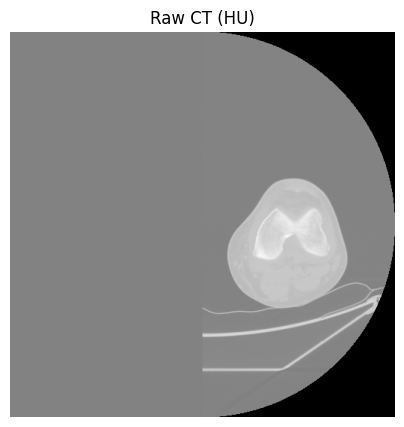

In [3]:

input_path  = "Original_mask\left_knee.nii.gz"           

# 2.2 Read CT
ct_sitk = sitk.ReadImage(input_path, sitk.sitkFloat32)
ct_np   = sitk_to_np(ct_sitk)
spacing = ct_sitk.GetSpacing()
print(f"Volume shape (z,y,x): {ct_np.shape}, spacing: {spacing} mm")

# 2.3 Show middle slice of raw CT
mid = ct_np.shape[0] // 2
plt.figure(figsize=(5,5))
plt.imshow(ct_np[mid], cmap='gray')
plt.title("Raw CT (HU)")
plt.axis('off')
plt.show()


---

## 3. Step 1: Thresholding (HU > 300)


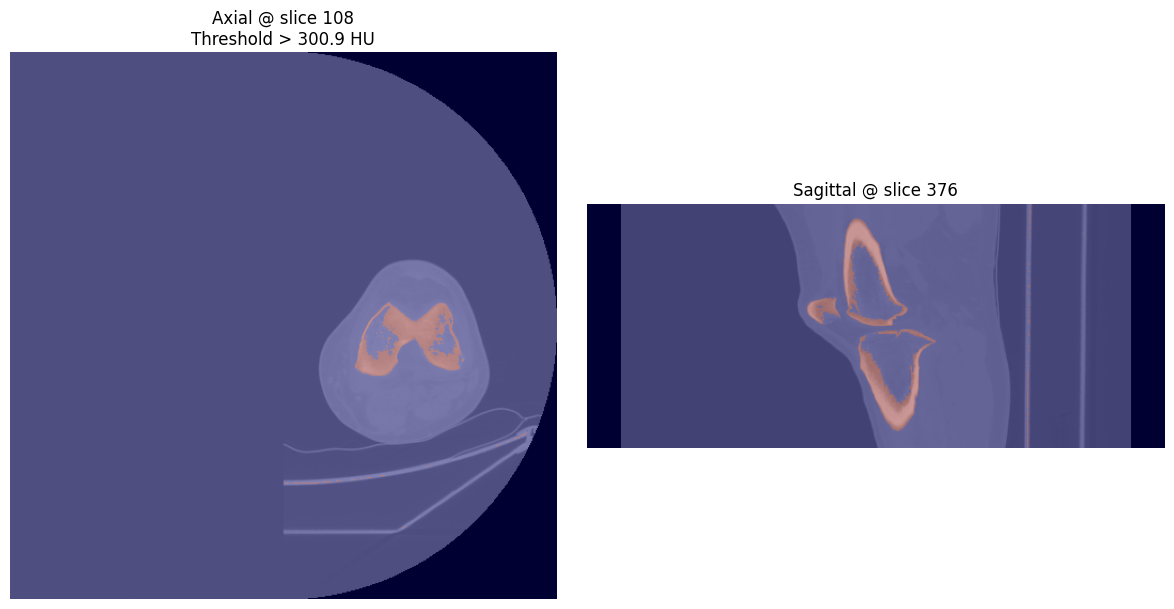

In [4]:
# 3.1 Binary threshold
hu_thresh = 300.9
bone_mask_sitk = sitk.BinaryThreshold(
    ct_sitk,
    lowerThreshold = hu_thresh,
    upperThreshold = 10000,
    insideValue    = 1,
    outsideValue   = 0
)
bone_np = sitk_to_np(bone_mask_sitk)

# 3.2 Visualize
mid_axial   = ct_np.shape[0] // 2       # z-axis
mid_sagittal =376   # x-axis

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# — Axial view —
ax0.imshow(ct_np[mid_axial], cmap='gray')
ax0.imshow(bone_np[mid_axial], cmap='jet', alpha=0.4)
ax0.set_title(f"Axial @ slice {mid_axial}\nThreshold > {hu_thresh} HU")
ax0.axis('off')

# — Sagittal (lateral) view —
sag_ct   = ct_np[:, :, mid_sagittal]
sag_mask = bone_np[:, :, mid_sagittal]

ax1.imshow(sag_ct,   cmap='gray', origin='lower')
ax1.imshow(sag_mask, cmap='jet',  alpha=0.4, origin='lower')
ax1.set_title(f"Sagittal @ slice {mid_sagittal}")
ax1.axis('off')

plt.tight_layout()
plt.show()


---

## 4. Step 2: Keep two largest connected components


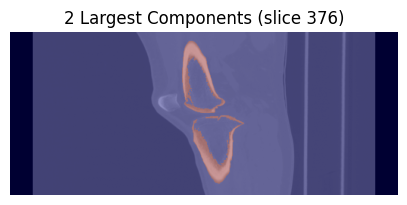

In [5]:
cc_sitk = sitk.ConnectedComponent(bone_mask_sitk)
relabeled = sitk.RelabelComponent(cc_sitk, sortByObjectSize=True)
two_largest_sitk = sitk.BinaryThreshold(
    relabeled,
    lowerThreshold = 1,
    upperThreshold = 2,
    insideValue    = 1,
    outsideValue   = 0
)
two_np = sitk_to_np(two_largest_sitk)
slice_idx=376
title="2 Largest Components"
alpha=0.4
plt.figure(figsize=(5,5))
plt.imshow(ct_np[:, :, slice_idx],cmap='gray',origin='lower')
plt.imshow(two_np[:, :, slice_idx], cmap='jet',origin='lower', alpha=alpha)
plt.title(f"{title} (slice {slice_idx})")
plt.axis('off')
plt.show()



---

## 5. Step 3: Morphological closing + hole fill


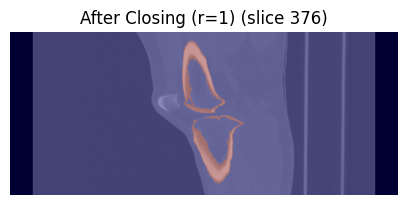

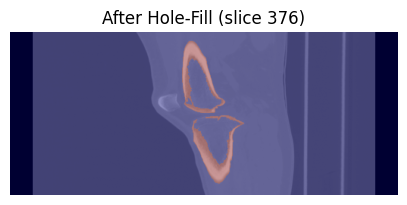

In [8]:
# 5.1 Closing
radius = 1
radius_vec = (radius,)*ct_sitk.GetDimension()
closed_sitk = sitk.BinaryMorphologicalClosing(two_largest_sitk, radius_vec)

# 5.2 Hole fill
filled_sitk = sitk.BinaryFillhole(closed_sitk, fullyConnected=True)

closed_np = sitk_to_np(closed_sitk)
filled_np = sitk_to_np(filled_sitk)

# 5.3 Visualize both
show_slice(ct_np, closed_np, 376, f"After Closing (r={radius})")
show_slice(ct_np, filled_np, 376,     "After Hole‐Fill")


In [7]:
# 1) Imports & Helpers
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball, dilation
from scipy.ndimage import distance_transform_edt

def sitk_to_np(img: sitk.Image) -> np.ndarray:
    """Convert sitk.Image to NumPy array with shape [z,y,x]"""
    return sitk.GetArrayFromImage(img)

def np_to_sitk(arr: np.ndarray, ref: sitk.Image) -> sitk.Image:
    """Convert boolean/uint8 array back to sitk.Image, copying spacing/origin/dir."""
    img = sitk.GetImageFromArray(arr.astype(np.uint8))
    img.CopyInformation(ref)
    return img

def show_slice(ct_np, mask_np, slice_idx, title, alpha=0.4):
    """Overlay mask on CT at one slice."""
    plt.figure(figsize=(5,5))
    plt.imshow(ct_np[:,:,slice_idx], cmap='gray',origin='lower')
    plt.imshow(mask_np[:,:,slice_idx], cmap='jet', alpha=alpha,origin='lower')
    plt.title(f"{title} (slice {slice_idx})")
    plt.axis('off')
    plt.show()


In [ ]:
# 2) Parameters & Read Original Mask
EXPAND_MMS   = [2.0, 4.0]                     # mm to expand by
RANDOM_MAX_MM = 2.0                            # max expansion for random masks
SEEDS        = [0, 42]                         # two different RNG seeds

# Read
orig_sitk = filled_sitk
orig_np   = sitk_to_np(orig_sitk).astype(bool)

# For visualization background you can load the CT again:
# ct_sitk = sitk.ReadImage("3702_left_knee.nii", sitk.sitkFloat32)
# ct_np   = sitk_to_np(ct_sitk)
# Here, we'll just use the original mask to compare:
ct_np = orig_np.astype(float)  # blank background
mid   = 376


Expanded by 2.0 mm → 444,262 voxels


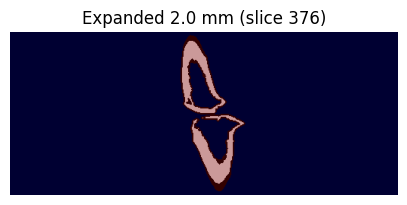

Expanded by 4.0 mm → 708,742 voxels


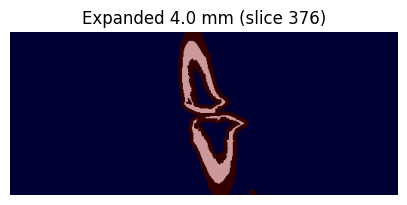

In [10]:
# 3) Mask Expansion Function
def expand_mask(orig_bool: np.ndarray, spacing: tuple, expand_mm: float) -> np.ndarray:
    """
    Expand a binary mask by expand_mm (in mm) using a spherical structuring element.
    """
    # Calculate approximate voxel radius using smallest spacing dimension
    voxel_radius = int(round(expand_mm / min(spacing)))  
    selem = ball(voxel_radius)  
    expanded = dilation(orig_bool, selem)
    return expanded

# Get spacing in array order (z,y,x)
spacing = orig_sitk.GetSpacing()[::-1]

# Apply expansions
expanded_results = {}
for mm in EXPAND_MMS:
    expanded_np = expand_mask(orig_np, spacing, mm)
    expanded_results[mm] = expanded_np
    print(f"Expanded by {mm} mm → {expanded_np.sum():,} voxels")
    show_slice(ct_np, expanded_np, mid, f"Expanded {mm} mm")


Randomized mask (seed=0) → 326,824 voxels


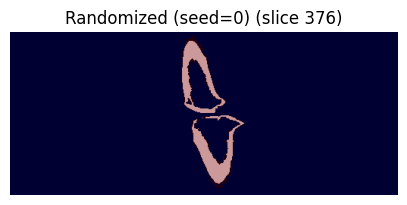

Randomized mask (seed=42) → 326,822 voxels


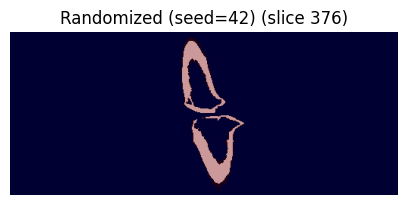

In [11]:
# 4) Randomized Mask Function
def random_perturbation(orig_bool: np.ndarray, spacing: tuple,
                        max_mm: float, seed: int) -> np.ndarray:
    """
    Given an original mask, randomly include outside voxels up to max_mm away.
    """
    rng = np.random.RandomState(seed)
    # Signed distance: outside positive, inside unused
    outside_dist = distance_transform_edt(~orig_bool, sampling=spacing)
    # Draw one random threshold per voxel
    r = rng.uniform(0, max_mm, size=orig_bool.shape)
    # Build new mask: keep orig + any outside voxel where dist <= r
    new_mask = orig_bool.copy()
    new_mask[(~orig_bool) & (outside_dist <= r)] = True
    return new_mask

# Generate & visualize
for seed in SEEDS:
    rand_np = random_perturbation(orig_np, spacing, RANDOM_MAX_MM, seed)
    print(f"Randomized mask (seed={seed}) → {rand_np.sum():,} voxels")
    show_slice(ct_np, rand_np, mid, f"Randomized (seed={seed})")
